In [1]:
import sys
import os

# Add Codes/src to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../src')))

In [2]:
import pandas as pd
import numpy as np
import torch
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import random

from train_utils import BatteryTrainerBase

In [3]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
df = pd.read_pickle('../../../Datasets/processed/merged_interp_flat.pkl')
df.head()

,cell_id,rated_capacity,cycle_index,capacity,soh,dqdt_min,dqdt_max,dqdt_mean,dqdt_std,dvdt_min,...,i_interp_991,i_interp_992,i_interp_993,i_interp_994,i_interp_995,i_interp_996,i_interp_997,i_interp_998,i_interp_999,source
0,B0005,2.0,1,1.856487,0.928244,-1.332504e-07,0.002876,0.000528,0.000255,-0.006229,...,0.004819,0.004902,0.004902,0.004902,0.004902,0.004902,0.004902,0.004902,0.004902,nasa
1,B0005,2.0,3,1.846327,0.923164,-4.510385e-07,0.002894,0.000527,0.000257,-0.006004,...,-0.000021,-0.000021,-0.000021,-0.000021,-0.000021,-0.000021,-0.000021,-0.000021,-0.000021,nasa
2,B0005,2.0,5,1.835349,0.917675,-1.163391e-07,0.002333,0.000520,0.000227,-0.005953,...,0.001754,0.001754,0.001754,0.001754,0.001754,0.001754,0.001754,0.001754,0.001754,nasa
3,B0005,2.0,7,1.835263,0.917631,-2.062661e-07,0.002885,0.000530,0.000255,-0.005907,...,0.002775,0.002775,0.002775,0.002775,0.002775,0.002775,0.002775,0.002775,0.002775,nasa
4,B0005,2.0,9,1.834646,0.917323,-5.353266e-07,0.002896,0.000530,0.000256,-0.005923,...,0.007981,0.007981,0.007981,0.007981,0.007981,0.007981,0.007981,0.007981,0.007981,nasa


In [5]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

class BatteryTrainer(BatteryTrainerBase):
    def train(self, train_df, val_df, feature_cols=None, n_estimators=100, learning_rate=0.1, max_depth=-1):
        ###
        # MODEL: LightGBM
        ###
        X_train = train_df[feature_cols].values
        y_train = train_df[self.target_cols].values.ravel()
        X_val = val_df[feature_cols].values
        y_val = val_df[self.target_cols].values.ravel()

        self.model = LGBMRegressor(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            random_state=42
        )
        self.model.fit(X_train, y_train)
        y_pred = self.model.predict(X_val)

        print(f"LightGBM Val MSE={mean_squared_error(y_val, y_pred):.4f}, MAE={mean_absolute_error(y_val, y_pred):.4f}, R²={r2_score(y_val, y_pred):.4f}")

        return self.model, y_val, y_pred

    def optuna_objective(self, trial):
        ###
        # Hyperparameter search for LightGBM
        ###
        n_estimators = trial.suggest_int("n_estimators", 50, 500)
        learning_rate = trial.suggest_float("learning_rate", 1e-3, 0.3, log=True)
        max_depth = trial.suggest_int("max_depth", -1, 20)

        self.cross_validate(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth
        )

        return np.mean(self.mse_scores)


In [6]:
trainer = BatteryTrainer(df, target_cols=['soh'])

In [7]:
result = trainer.cross_validate()


=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 7177, number of used features: 2001
[LightGBM] [Info] Start training from score 0.835779


c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM Val MSE=0.0013, MAE=0.0166, R²=0.9765
  MSE: 0.0013, MAE: 0.0166, R²: 0.9765

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069894 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 6968, number of used features: 2001
[LightGBM] [Info] Start training from score 0.825550


c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM Val MSE=0.0018, MAE=0.0221, R²=0.9464
  MSE: 0.0018, MAE: 0.0221, R²: 0.9464

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 6823, number of used features: 2001
[LightGBM] [Info] Start training from score 0.830394


c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM Val MSE=0.0009, MAE=0.0130, R²=0.9796
  MSE: 0.0009, MAE: 0.0130, R²: 0.9796

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 7204, number of used features: 2001
[LightGBM] [Info] Start training from score 0.822709


c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM Val MSE=0.0027, MAE=0.0185, R²=0.9285
  MSE: 0.0027, MAE: 0.0185, R²: 0.9285

=== Fold 5 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 7236, number of used features: 2001
[LightGBM] [Info] Start training from score 0.838509
LightGBM Val MSE=0.0010, MAE=0.0115, R²=0.9867
  MSE: 0.0010, MAE: 0.0115, R²: 0.9867

=== Average CV Performance ===
Avg MSE: 0.0016
Avg MAE: 0.0163
Avg R² : 0.9635


c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [8]:
study = trainer.run_optuna_tuning()

[I 2025-04-17 11:44:32,665] A new study created in memory with name: no-name-92e23d74-a784-448b-94ea-2e0419a445df



=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 7177, number of used features: 2001
[LightGBM] [Info] Start training from score 0.835779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM Val MSE=0.0016, MAE=0.0189, R²=0.9725
  MSE: 0.0016, MAE: 0.0189, R²: 0.9725

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 6968, number of used features: 2001
[LightGBM] [Info] Start training from score 0.825550
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 6823, number of used features: 2001
[LightGBM] [Info] Start training from score 0.830394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM Val MSE=0.0009, MAE=0.0132, R²=0.9799
  MSE: 0.0009, MAE: 0.0132, R²: 0.9799

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 7204, number of used features: 2001
[LightGBM] [Info] Start training from score 0.822709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM Val MSE=0.0023, MAE=0.0180, R²=0.9381
  MSE: 0.0023, MAE: 0.0180, R²: 0.9381

=== Fold 5 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 7236, number of used features: 2001
[LightGBM] [Info] Start training from score 0.838509
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-04-17 11:45:30,030] Trial 0 finished with value: 0.0015738692516927568 and parameters: {'n_estimators': 218, 'learning_rate': 0.22648248189516848, 'max_depth': 15}. Best is trial 0 with value: 0.0015738692516927568.


LightGBM Val MSE=0.0012, MAE=0.0151, R²=0.9830
  MSE: 0.0012, MAE: 0.0151, R²: 0.9830

=== Average CV Performance ===
Avg MSE: 0.0016
Avg MAE: 0.0176
Avg R² : 0.9640

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 7177, number of used features: 2001
[LightGBM] [Info] Start training from score 0.835779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 6968, number of used features: 2001
[LightGBM] [Info] Start training from score 0.825550
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM Val MSE=0.0137, MAE=0.0900, R²=0.5994
  MSE: 0.0137, MAE: 0.0900, R²: 0.5994

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 6823, number of used features: 2001
[LightGBM] [Info] Start training from score 0.830394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 7204, number of used features: 2001
[LightGBM] [Info] Start training from score 0.822709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM Val MSE=0.0169, MAE=0.1013, R²=0.5499
  MSE: 0.0169, MAE: 0.1013, R²: 0.5499

=== Fold 5 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 7236, number of used features: 2001
[LightGBM] [Info] Start training from score 0.838509
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-04-17 11:45:55,460] Trial 1 finished with value: 0.019892009640843762 and parameters: {'n_estimators': 319, 'learning_rate': 0.0024348773534554596, 'max_depth': 2}. Best is trial 0 with value: 0.0015738692516927568.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGBM Val MSE=0.0277, MAE=0.1136, R²=0.6152
  MSE: 0.0277, MAE: 0.1136, R²: 0.6152

=== Average CV Performance ===
Avg MSE: 0.0199
Avg MAE: 0.1045
Avg R² : 0.5923

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 7177, number of used features: 2001
[LightGBM] [Info] Start training from score 0.835779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM Val MSE=0.0017, MAE=0.0193, R²=0.9711
  MSE: 0.0017, MAE: 0.0193, R²: 0.9711

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 6968, number of used features: 2001
[LightGBM] [Info] Start training from score 0.825550
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM Val MSE=0.0016, MAE=0.0210, R²=0.9521
  MSE: 0.0016, MAE: 0.0210, R²: 0.9521

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 6823, number of used features: 2001
[LightGBM] [Info] Start training from score 0.830394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM Val MSE=0.0009, MAE=0.0129, R²=0.9794
  MSE: 0.0009, MAE: 0.0129, R²: 0.9794

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076708 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 7204, number of used features: 2001
[LightGBM] [Info] Start training from score 0.822709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGBM Val MSE=0.0027, MAE=0.0189, R²=0.9273
  MSE: 0.0027, MAE: 0.0189, R²: 0.9273

=== Fold 5 ===


c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 7236, number of used features: 2001
[LightGBM] [Info] Start training from score 0.838509
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-04-17 11:46:26,976] Trial 2 finished with value: 0.001593334354074958 and parameters: {'n_estimators': 76, 'learning_rate': 0.13983740016490973, 'max_depth': 12}. Best is trial 0 with value: 0.0015738692516927568.


LightGBM Val MSE=0.0010, MAE=0.0123, R²=0.9861
  MSE: 0.0010, MAE: 0.0123, R²: 0.9861

=== Average CV Performance ===
Avg MSE: 0.0016
Avg MAE: 0.0169
Avg R² : 0.9632

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 7177, number of used features: 2001
[LightGBM] [Info] Start training from score 0.835779


c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM Val MSE=0.0263, MAE=0.1253, R²=0.5391
  MSE: 0.0263, MAE: 0.1253, R²: 0.5391

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071825 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 6968, number of used features: 2001
[LightGBM] [Info] Start training from score 0.825550


c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM Val MSE=0.0155, MAE=0.0973, R²=0.5479
  MSE: 0.0155, MAE: 0.0973, R²: 0.5479

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076621 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 6823, number of used features: 2001
[LightGBM] [Info] Start training from score 0.830394


c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM Val MSE=0.0213, MAE=0.1115, R²=0.5344
  MSE: 0.0213, MAE: 0.1115, R²: 0.5344

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 7204, number of used features: 2001
[LightGBM] [Info] Start training from score 0.822709


c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM Val MSE=0.0205, MAE=0.1136, R²=0.4540
  MSE: 0.0205, MAE: 0.1136, R²: 0.4540

=== Fold 5 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 7236, number of used features: 2001
[LightGBM] [Info] Start training from score 0.838509


c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-04-17 11:48:23,485] Trial 3 finished with value: 0.023481039605694382 and parameters: {'n_estimators': 369, 'learning_rate': 0.001124579825911934, 'max_depth': 20}. Best is trial 0 with value: 0.0015738692516927568.


LightGBM Val MSE=0.0338, MAE=0.1308, R²=0.5303
  MSE: 0.0338, MAE: 0.1308, R²: 0.5303

=== Average CV Performance ===
Avg MSE: 0.0235
Avg MAE: 0.1157
Avg R² : 0.5211

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 7177, number of used features: 2001
[LightGBM] [Info] Start training from score 0.835779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM Val MSE=0.0089, MAE=0.0708, R²=0.8441
  MSE: 0.0089, MAE: 0.0708, R²: 0.8441

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 6968, number of used features: 2001
[LightGBM] [Info] Start training from score 0.825550
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068888 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 6823, number of used features: 2001
[LightGBM] [Info] Start training from score 0.830394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 7204, number of used features: 2001
[LightGBM] [Info] Start training from score 0.822709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 7236, number of used features: 2001
[LightGBM] [Info] Start training from score 0.838509
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-04-17 11:49:16,586] Trial 4 finished with value: 0.007737040365766478 and parameters: {'n_estimators': 425, 'learning_rate': 0.0033572967053517922, 'max_depth': 3}. Best is trial 0 with value: 0.0015738692516927568.


LightGBM Val MSE=0.0089, MAE=0.0653, R²=0.8766
  MSE: 0.0089, MAE: 0.0653, R²: 0.8766

=== Average CV Performance ===
Avg MSE: 0.0077
Avg MAE: 0.0666
Avg R² : 0.8370

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 7177, number of used features: 2001
[LightGBM] [Info] Start training from score 0.835779


c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM Val MSE=0.0143, MAE=0.0907, R²=0.7505
  MSE: 0.0143, MAE: 0.0907, R²: 0.7505

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 6968, number of used features: 2001
[LightGBM] [Info] Start training from score 0.825550


c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM Val MSE=0.0086, MAE=0.0726, R²=0.7483
  MSE: 0.0086, MAE: 0.0726, R²: 0.7483

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 6823, number of used features: 2001
[LightGBM] [Info] Start training from score 0.830394


c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM Val MSE=0.0122, MAE=0.0837, R²=0.7346
  MSE: 0.0122, MAE: 0.0837, R²: 0.7346

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.104558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 7204, number of used features: 2001
[LightGBM] [Info] Start training from score 0.822709


c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM Val MSE=0.0131, MAE=0.0872, R²=0.6509
  MSE: 0.0131, MAE: 0.0872, R²: 0.6509

=== Fold 5 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 7236, number of used features: 2001
[LightGBM] [Info] Start training from score 0.838509


c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-04-17 11:50:28,965] Trial 5 finished with value: 0.013337707597814113 and parameters: {'n_estimators': 132, 'learning_rate': 0.005670807781371429, 'max_depth': 10}. Best is trial 0 with value: 0.0015738692516927568.


LightGBM Val MSE=0.0186, MAE=0.0957, R²=0.7419
  MSE: 0.0186, MAE: 0.0957, R²: 0.7419

=== Average CV Performance ===
Avg MSE: 0.0133
Avg MAE: 0.0860
Avg R² : 0.7252

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 7177, number of used features: 2001
[LightGBM] [Info] Start training from score 0.835779


c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM Val MSE=0.0060, MAE=0.0564, R²=0.8946
  MSE: 0.0060, MAE: 0.0564, R²: 0.8946

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085842 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 6968, number of used features: 2001
[LightGBM] [Info] Start training from score 0.825550


c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM Val MSE=0.0039, MAE=0.0484, R²=0.8850
  MSE: 0.0039, MAE: 0.0484, R²: 0.8850

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 6823, number of used features: 2001
[LightGBM] [Info] Start training from score 0.830394


c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM Val MSE=0.0054, MAE=0.0546, R²=0.8815
  MSE: 0.0054, MAE: 0.0546, R²: 0.8815

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 7204, number of used features: 2001
[LightGBM] [Info] Start training from score 0.822709


c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM Val MSE=0.0072, MAE=0.0590, R²=0.8071
  MSE: 0.0072, MAE: 0.0590, R²: 0.8071

=== Fold 5 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 7236, number of used features: 2001
[LightGBM] [Info] Start training from score 0.838509


c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-04-17 11:52:02,240] Trial 6 finished with value: 0.006066959877686753 and parameters: {'n_estimators': 244, 'learning_rate': 0.005265139631677754, 'max_depth': 12}. Best is trial 0 with value: 0.0015738692516927568.


LightGBM Val MSE=0.0077, MAE=0.0605, R²=0.8928
  MSE: 0.0077, MAE: 0.0605, R²: 0.8928

=== Average CV Performance ===
Avg MSE: 0.0061
Avg MAE: 0.0558
Avg R² : 0.8722

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 7177, number of used features: 2001
[LightGBM] [Info] Start training from score 0.835779


c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM Val MSE=0.0189, MAE=0.1052, R²=0.6699
  MSE: 0.0189, MAE: 0.1052, R²: 0.6699

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 6968, number of used features: 2001
[LightGBM] [Info] Start training from score 0.825550


c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM Val MSE=0.0112, MAE=0.0823, R²=0.6738
  MSE: 0.0112, MAE: 0.0823, R²: 0.6738

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 6823, number of used features: 2001
[LightGBM] [Info] Start training from score 0.830394


c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM Val MSE=0.0158, MAE=0.0956, R²=0.6563
  MSE: 0.0158, MAE: 0.0956, R²: 0.6563

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 7204, number of used features: 2001
[LightGBM] [Info] Start training from score 0.822709


c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM Val MSE=0.0160, MAE=0.0984, R²=0.5736
  MSE: 0.0160, MAE: 0.0984, R²: 0.5736

=== Fold 5 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 7236, number of used features: 2001
[LightGBM] [Info] Start training from score 0.838509


c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-04-17 11:52:44,036] Trial 7 finished with value: 0.01725940002033675 and parameters: {'n_estimators': 112, 'learning_rate': 0.005292705365436975, 'max_depth': 7}. Best is trial 0 with value: 0.0015738692516927568.


LightGBM Val MSE=0.0245, MAE=0.1106, R²=0.6590
  MSE: 0.0245, MAE: 0.1106, R²: 0.6590

=== Average CV Performance ===
Avg MSE: 0.0173
Avg MAE: 0.0984
Avg R² : 0.6465

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 7177, number of used features: 2001
[LightGBM] [Info] Start training from score 0.835779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM Val MSE=0.0022, MAE=0.0231, R²=0.9609
  MSE: 0.0022, MAE: 0.0231, R²: 0.9609

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 6968, number of used features: 2001
[LightGBM] [Info] Start training from score 0.825550
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM Val MSE=0.0013, MAE=0.0226, R²=0.9617
  MSE: 0.0013, MAE: 0.0226, R²: 0.9617

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 6823, number of used features: 2001
[LightGBM] [Info] Start training from score 0.830394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069868 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 7204, number of used features: 2001
[LightGBM] [Info] Start training from score 0.822709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM Val MSE=0.0018, MAE=0.0220, R²=0.9525
  MSE: 0.0018, MAE: 0.0220, R²: 0.9525

=== Fold 5 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080758 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 7236, number of used features: 2001
[LightGBM] [Info] Start training from score 0.838509
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-04-17 11:53:10,998] Trial 8 finished with value: 0.0015043242406857778 and parameters: {'n_estimators': 255, 'learning_rate': 0.08810003129071789, 'max_depth': 3}. Best is trial 8 with value: 0.0015043242406857778.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM Val MSE=0.0015, MAE=0.0175, R²=0.9740
  MSE: 0.0015, MAE: 0.0175, R²: 0.9740

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071729 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 6968, number of used features: 2001
[LightGBM] [Info] Start training from score 0.825550


c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM Val MSE=0.0016, MAE=0.0210, R²=0.9520
  MSE: 0.0016, MAE: 0.0210, R²: 0.9520

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 6823, number of used features: 2001
[LightGBM] [Info] Start training from score 0.830394


c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM Val MSE=0.0009, MAE=0.0124, R²=0.9796
  MSE: 0.0009, MAE: 0.0124, R²: 0.9796

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 7204, number of used features: 2001
[LightGBM] [Info] Start training from score 0.822709


c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM Val MSE=0.0024, MAE=0.0173, R²=0.9360
  MSE: 0.0024, MAE: 0.0173, R²: 0.9360

=== Fold 5 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 7236, number of used features: 2001
[LightGBM] [Info] Start training from score 0.838509


c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-04-17 11:54:30,518] Trial 9 finished with value: 0.0014858650570119722 and parameters: {'n_estimators': 281, 'learning_rate': 0.029341527565000736, 'max_depth': 0}. Best is trial 9 with value: 0.0014858650570119722.


LightGBM Val MSE=0.0010, MAE=0.0114, R²=0.9865
  MSE: 0.0010, MAE: 0.0114, R²: 0.9865

=== Average CV Performance ===
Avg MSE: 0.0015
Avg MAE: 0.0159
Avg R² : 0.9656

Best trial:
  MSE: 0.0015
  Params:
    n_estimators: 281
    learning_rate: 0.029341527565000736
    max_depth: 0


In [9]:
base_model = trainer.train_base_model()


Training base model with default hyperparameters
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 7177, number of used features: 2001
[LightGBM] [Info] Start training from score 0.835779
LightGBM Val MSE=0.0018, MAE=0.0182, R²=0.9683


c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [10]:
tuned_model = trainer.train_tuned_model()


Training with best Optuna params:
  n_estimators: 281
  learning_rate: 0.029341527565000736
  max_depth: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 7177, number of used features: 2001
[LightGBM] [Info] Start training from score 0.835779
LightGBM Val MSE=0.0018, MAE=0.0180, R²=0.9686


c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



Running cross-validation for base model...

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 7177, number of used features: 2001
[LightGBM] [Info] Start training from score 0.835779


c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM Val MSE=0.0013, MAE=0.0166, R²=0.9765
  MSE: 0.0013, MAE: 0.0166, R²: 0.9765

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 6968, number of used features: 2001
[LightGBM] [Info] Start training from score 0.825550


c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM Val MSE=0.0018, MAE=0.0221, R²=0.9464
  MSE: 0.0018, MAE: 0.0221, R²: 0.9464

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069946 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 6823, number of used features: 2001
[LightGBM] [Info] Start training from score 0.830394


c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM Val MSE=0.0009, MAE=0.0130, R²=0.9796
  MSE: 0.0009, MAE: 0.0130, R²: 0.9796

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 7204, number of used features: 2001
[LightGBM] [Info] Start training from score 0.822709


c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM Val MSE=0.0027, MAE=0.0185, R²=0.9285
  MSE: 0.0027, MAE: 0.0185, R²: 0.9285

=== Fold 5 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 7236, number of used features: 2001
[LightGBM] [Info] Start training from score 0.838509


c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM Val MSE=0.0010, MAE=0.0115, R²=0.9867
  MSE: 0.0010, MAE: 0.0115, R²: 0.9867

=== Average CV Performance ===
Avg MSE: 0.0016
Avg MAE: 0.0163
Avg R² : 0.9635

Running cross-validation for tuned model...

=== Fold 1 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 7177, number of used features: 2001
[LightGBM] [Info] Start training from score 0.835779


c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM Val MSE=0.0015, MAE=0.0175, R²=0.9740
  MSE: 0.0015, MAE: 0.0175, R²: 0.9740

=== Fold 2 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072850 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 6968, number of used features: 2001
[LightGBM] [Info] Start training from score 0.825550


c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM Val MSE=0.0016, MAE=0.0210, R²=0.9520
  MSE: 0.0016, MAE: 0.0210, R²: 0.9520

=== Fold 3 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 6823, number of used features: 2001
[LightGBM] [Info] Start training from score 0.830394


c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM Val MSE=0.0009, MAE=0.0124, R²=0.9796
  MSE: 0.0009, MAE: 0.0124, R²: 0.9796

=== Fold 4 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 7204, number of used features: 2001
[LightGBM] [Info] Start training from score 0.822709


c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM Val MSE=0.0024, MAE=0.0173, R²=0.9360
  MSE: 0.0024, MAE: 0.0173, R²: 0.9360

=== Fold 5 ===
[nasa] Normalizing 2014 features
[oxford] Normalizing 2014 features
[isu] Normalizing 2014 features
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510255
[LightGBM] [Info] Number of data points in the train set: 7236, number of used features: 2001
[LightGBM] [Info] Start training from score 0.838509


c:\Users\chris\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\chris\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\chris\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\chris\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_sub

LightGBM Val MSE=0.0010, MAE=0.0114, R²=0.9865
  MSE: 0.0010, MAE: 0.0114, R²: 0.9865

=== Average CV Performance ===
Avg MSE: 0.0015
Avg MAE: 0.0159
Avg R² : 0.9656


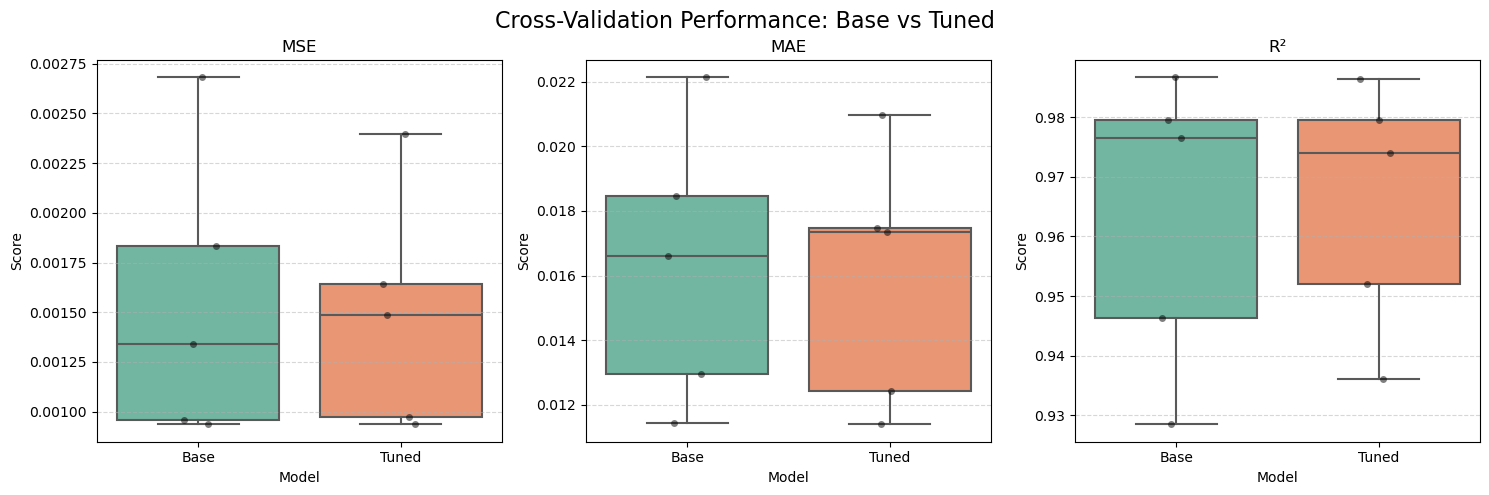

In [11]:
trainer.compare_base_vs_tuned_cv()